In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from datetime import timedelta
from statsmodels.tsa.arima.model import ARIMA
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate

In [12]:
df = pd.read_csv("library_data.csv")

In [13]:
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df.set_index("Date", inplace=True)

In [14]:
daily_transactions = df.resample("D").sum()["Amount"]

In [15]:
arma_model = ARIMA(daily_transactions, order=(2, 0, 2))  # ARMA(p=2, q=2)
arma_results = arma_model.fit()

C:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [16]:
future_dates = [daily_transactions.index[-1] + timedelta(days=i) for i in range(1, 31)]
future_forecast = arma_results.forecast(steps=30)

In [17]:
future_df = pd.DataFrame({"Date": future_dates, "Predicted_Amount": future_forecast})
future_df.to_csv("future_predictions.csv", index=False)

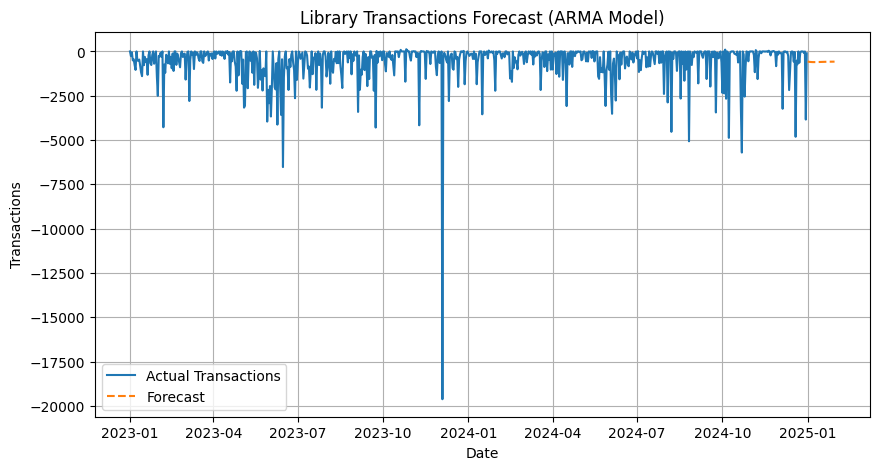

✅ ARMA Model trained and future predictions saved!


In [18]:
plt.figure(figsize=(10, 5))
plt.plot(daily_transactions.index, daily_transactions, label="Actual Transactions")
plt.plot(future_df["Date"], future_df["Predicted_Amount"], label="Forecast", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Transactions")
plt.title("Library Transactions Forecast (ARMA Model)")
plt.legend()
plt.grid()
plt.show()

print("✅ ARMA Model trained and future predictions saved!")

In [19]:
reader = Reader(rating_scale=(0, 50))  # Adjust range based on data
data = Dataset.load_from_df(df.reset_index()[["card_number", "Clean_Title", "Amount"]], reader)


In [20]:
svd_model = SVD()
cross_validate(svd_model, data, cv=5)

{'test_rmse': array([ 99.59758489,  90.15606425, 111.64337603, 111.49915568,
        235.60933402]),
 'test_mae': array([57.08367259, 56.48510821, 58.68202271, 59.44133719, 61.53905497]),
 'fit_time': (0.2493274211883545,
  0.2502865791320801,
  0.26242613792419434,
  0.25603628158569336,
  0.299680233001709),
 'test_time': (0.02814483642578125,
  0.01799607276916504,
  0.025243043899536133,
  0.03186488151550293,
  0.016052961349487305)}

In [21]:
trainset = data.build_full_trainset()
svd_model.fit(trainset)


In [22]:
with open("svd_model.pkl", "wb") as f:
    pickle.dump(svd_model, f)

In [23]:
def recommend_books(user_id, num_recommendations=5):
    book_ids = df["Clean_Title"].unique()
    predictions = [(book, svd_model.predict(user_id, book).est) for book in book_ids]
    recommendations = sorted(predictions, key=lambda x: x[1], reverse=True)[:num_recommendations]
    return [book for book, _ in recommendations]

In [24]:
print("Recommended books for user '9D3NHL':", recommend_books("9D3NHL"))

Recommended books for user '9D3NHL': ['data communication and networking', 'data science and big data analytics', 'digital computer electronics introduction to micro computer', 'estimating  costing in civil engineering', 'cloud computing theory and practice']


In [25]:
df.to_csv("processed_data.csv", index=False)